In [17]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
 
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np


airbnb_data = pd.read_csv("cleaned_airbnb_Chicago.csv")

predicting revenue using xgboost

In [24]:
##Modelling to predict revenue for the tracts identified in the previous clusters

##Cluster Mapping
tracts_cluster_2 = [17031671800]             
 
# List of numerical and categorical columns
numerical_cols = ['available_days', 'booked_days', 'Bedrooms', 'Bathrooms', 'Max Guests',
                  'Cleaning Fee (USD)', 'Minimum Stay', 'Number of Photos','Nightly Rate',
                  'Number of Reviews', 'Rating Overall', 'occupancy_rate', 'Instantbook Enabled']
 
categorical_cols = ['Property Type', 'Listing Type']
 
# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
 
# Separate features and target variable
X = airbnb_data.drop('revenue', axis=1)
y = airbnb_data['revenue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 

# Define the Gradient Boosting model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', 
        n_estimators=100, learning_rate=0.1, max_depth=5))
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
 
# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

# Get feature importances
feature_importances = model.named_steps['regressor'].feature_importances_
preprocessor = model.named_steps['preprocessor']
 
# Adjust this line to be compatible with your version of sklearn
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols) if hasattr(OneHotEncoder, 'get_feature_names_out') else preprocessor.named_transformers_['cat'].get_feature_names(categorical_cols)
all_features = numerical_cols + list(cat_feature_names)
 
# Assuming y_test are the actual values and y_pred are the predicted values from the model
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared:.2f}')
 
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
# Assuming y_test are the actual values and y_pred are the predicted values from the model
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
 
# Set a threshold for important features
importance_threshold = 0.01
 
# Sort the features by importance
sorted_indices = feature_importances.argsort()[::-1]
print("\nImportant Features:")
for idx in sorted_indices:
    if feature_importances[idx] >= importance_threshold:
        print(f"{all_features[idx]}: {feature_importances[idx]}")
 

Root Mean Squared Error: 1802.19
R-squared: 0.84
Mean Absolute Percentage Error (MAPE): 34.15%

Important Features:
Nightly Rate: 0.2538187503814697
booked_days: 0.1636708527803421
Max Guests: 0.09001976996660233
Cleaning Fee (USD): 0.07827784866094589
Bedrooms: 0.07005216926336288
Listing Type_Entire home/apt: 0.06625484675168991
Bathrooms: 0.05670761689543724
Property Type_Serviced apartment: 0.03849263861775398
Instantbook Enabled: 0.025097953155636787
Property Type_Apartment: 0.02262592874467373
Property Type_Loft: 0.01675909385085106
occupancy_rate: 0.013396119698882103
Number of Reviews: 0.011616077274084091
Property Type_House: 0.011425353586673737
Rating Overall: 0.01062480453401804
Number of Photos: 0.010471144691109657


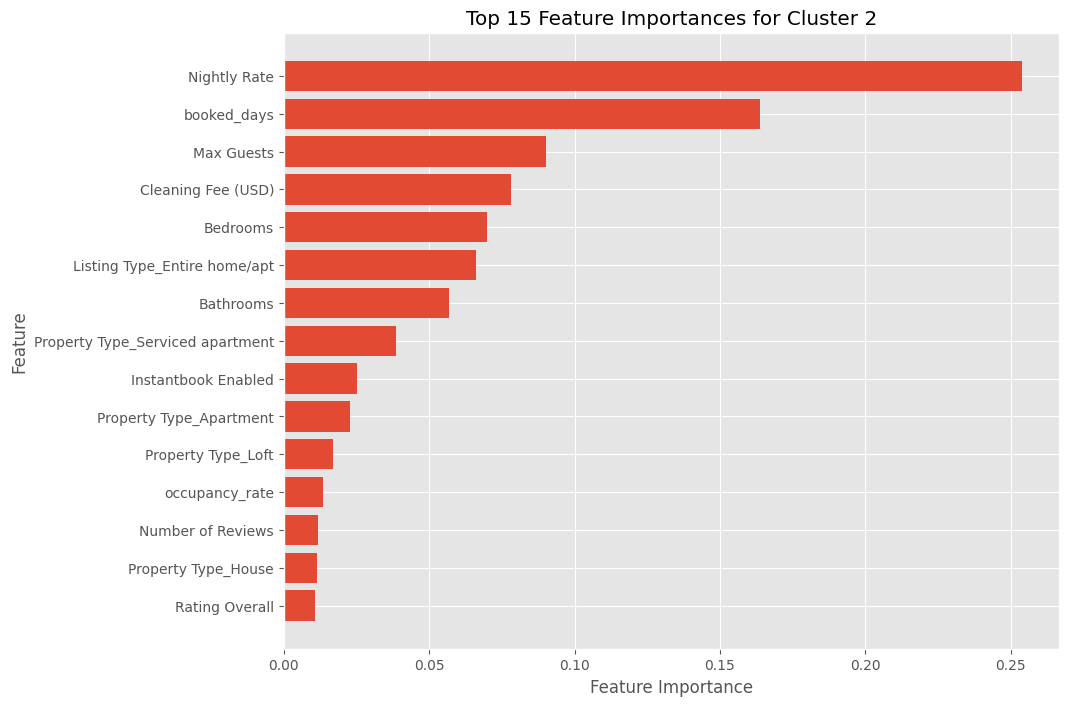

In [21]:
import matplotlib.pyplot as plt

# Combining feature names and their importances
feature_importance_dict = dict(zip(all_features, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Take only the top n features
top_features = sorted_features[:15]

# Separate feature names and their importance scores
top_features_names = [item[0] for item in top_features]
top_features_importances = [item[1] for item in top_features]

plt.style.use('ggplot')

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_features_names, top_features_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances for Cluster 2')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

Predicting revenue with linear regression

In [22]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from patsy import dmatrices

# Define numerical and categorical columns
numerical_cols = ['available_days', 'booked_days', 'Bedrooms', 'Bathrooms', 'Max Guests',
                  'Cleaning Fee (USD)', 'Minimum Stay', 'Number of Photos', 'Nightly Rate',
                  'Number of Reviews', 'Rating Overall', 'occupancy_rate', 'Instantbook Enabled']
categorical_cols = ['Property Type', 'Listing Type']

# Prepare the formula
def prepare_formula(numerical_cols, categorical_cols):
    formatted_numerical_cols = [f'Q("{col}")' for col in numerical_cols]
    formatted_categorical_cols = [f'C(Q("{col}"))' for col in categorical_cols]
    formula = 'revenue ~ ' + ' + '.join(formatted_numerical_cols + formatted_categorical_cols)
    return formula

formula = prepare_formula(numerical_cols, categorical_cols)

# Create design matrices
y, X = dmatrices(formula, airbnb_data, return_type='dataframe')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using Statsmodels
model = sm.OLS(y_train, X_train)
results = model.fit()

# Print the summary of the model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     1253.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:17:16   Log-Likelihood:            -6.1268e+05
No. Observations:               64995   AIC:                         1.226e+06
Df Residuals:                   64915   BIC:                         1.226e+06
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Define your input variables and target variable
input_columns = ['Nightly Rate', 'booked_days', 'Max Guests', 'Cleaning Fee (USD)', 
                 'Bedrooms', 'Listing Type', 'Bathrooms', 'Property Type',
                 'Instantbook Enabled', 'occupancy_rate', 'Number of Reviews', 
                 'Rating Overall']

target_column = 'revenue'

# Create your input and target DataFrames
X = airbnb_data[input_columns]
y = airbnb_data[target_column]

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['Listing Type', 'Property Type'], drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (optional but can be helpful)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients and p-values (p-values are not provided directly by scikit-learn)
coefficients = model.coef_
p_values = [0]  # Placeholder for p-values (you can calculate them separately if needed)

# print(coefficients)
# Print coefficients and p-values (placeholders for p-values)

column_names = []
reg_coefficients = []
for i, column in enumerate(X.columns):
    if column in top_features_names:
    # print(f'{column}: Coefficient={coefficients[i]:.4f}')
        column_names.append(column)
        reg_coefficients.append(coefficients[i])

coefficients_df = pd.DataFrame({'Feature': column_names, 'Coefficient': reg_coefficients})

# Print or further analyze the coefficients DataFrame
print(coefficients_df)


                             Feature  Coefficient
0                       Nightly Rate  1910.665476
1                        booked_days  2512.471131
2                         Max Guests   416.335435
3                 Cleaning Fee (USD)   397.689959
4                           Bedrooms   346.070473
5                          Bathrooms   322.317552
6                Instantbook Enabled   -39.409246
7                     occupancy_rate    52.010264
8                  Number of Reviews   -65.487439
9                     Rating Overall   129.692886
10               Property Type_House  -145.574027
11                Property Type_Loft    71.009244
12  Property Type_Serviced apartment   -54.188597


In [44]:
print(coefficients)

[]
